In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset (update the path to where your dataset is located)
df = pd.read_csv("/online_retail_II.csv", encoding='unicode_escape')

# Check the first few rows
df.head()


Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [19]:
# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove canceled orders (assuming 'Invoice' starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Calculate TotalAmount for each row (Quantity * Price)
df['TotalAmount'] = df['Quantity'] * df['Price']

# Remove rows with missing 'CustomerID' and 'TotalAmount'
df.dropna(subset=['Customer ID', 'TotalAmount'], inplace=True)

# Check data after cleaning
df.head()

<ipython-input-19-b6c411d94330>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalAmount'] = df['Quantity'] * df['Price']
<ipython-input-19-b6c411d94330>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Customer ID', 'TotalAmount'], inplace=True)


Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalAmount  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom         83.4  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom         81.0  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom         81.0  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom        100.8  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom         30.0

In [21]:
# Check the columns in the dataset to ensure 'CustomerID' exists
df.columns


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'TotalAmount'],
      dtype='object')

In [22]:
# Strip any leading/trailing spaces from the column names
df.columns = df.columns.str.strip()

# Verify column names to make sure they are cleaned
df.columns


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'TotalAmount'],
      dtype='object')

In [23]:
# Define the snapshot date as the latest date in the dataset
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create a new dataframe to calculate RFM features
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

# Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Check the first few rows of the RFM dataframe
rfm.head()


CustomerID  Recency  Frequency  Monetary
0     12346.0      326         12  77556.46
1     12347.0        2          8   5633.32
2     12348.0       75          5   2019.40
3     12349.0       19          4   4428.69
4     12350.0      310          1    334.40

In [24]:
from sklearn.preprocessing import StandardScaler

# Standardize the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Convert the result back into a DataFrame for easier handling
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Check the first few rows of the standardized RFM data
rfm_scaled_df.head()


Recency  Frequency  Monetary
0  0.594598   0.439049  5.059391
1 -0.952264   0.131635  0.177579
2 -0.603743  -0.098925 -0.067718
3 -0.871102  -0.175779  0.095814
4  0.518209  -0.406339 -0.182088

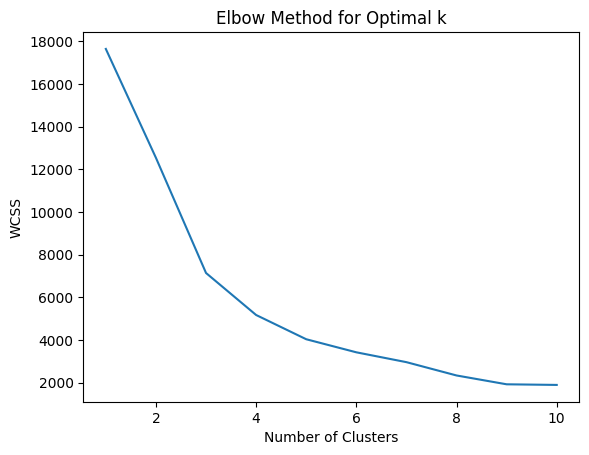

In [25]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [26]:
# Apply K-means with the chosen number of clusters (e.g., k=5)
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# Check the first few rows of the RFM dataframe with the assigned clusters
rfm.head()


CustomerID  Recency  Frequency  Monetary  Cluster
0     12346.0      326         12  77556.46        4
1     12347.0        2          8   5633.32        0
2     12348.0       75          5   2019.40        0
3     12349.0       19          4   4428.69        0
4     12350.0      310          1    334.40        1

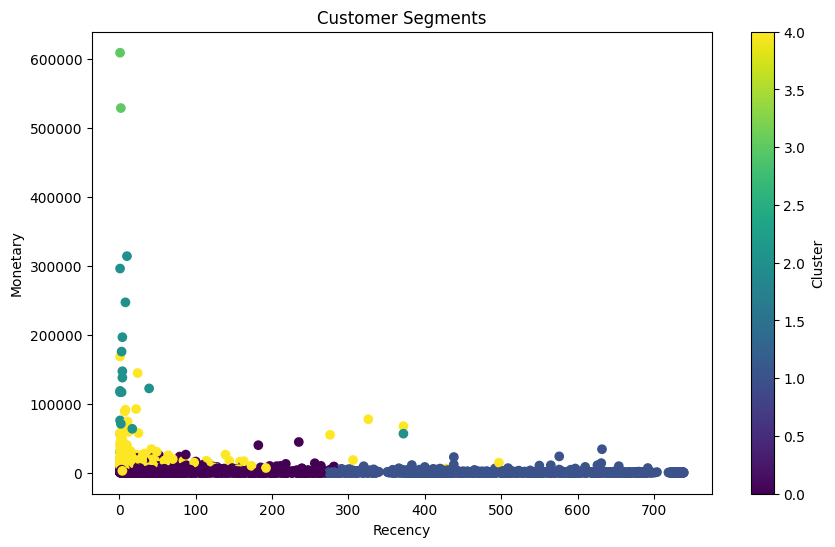

In [27]:
# Visualizing the clusters (using Recency and Monetary for simplicity)
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
plt.title('Customer Segments')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.colorbar(label='Cluster')
plt.show()


In [28]:
# Analyze the clusters by calculating the mean of RFM features per cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Check the cluster summary
cluster_summary


Cluster     Recency   Frequency       Monetary
0        0   74.267201    5.405913    2036.372985
1        1  470.369103    2.159668     752.707016
2        2   27.764706  161.176471  137806.995294
3        3    1.500000  148.500000  568712.085000
4        4   26.060510   32.509554   17330.192430

In [29]:
# Assign labels to clusters based on the characteristics
cluster_labels = {
    0: 'Low Value Customers',
    1: 'Frequent Shoppers',
    2: 'High Value Customers',
    3: 'Occasional Shoppers',
    4: 'At Risk Customers'
}

# Map the labels to the cluster column
rfm['ClusterLabel'] = rfm['Cluster'].map(cluster_labels)

# Check the updated dataframe with cluster labels
rfm.head()


CustomerID  Recency  Frequency  Monetary  Cluster         ClusterLabel
0     12346.0      326         12  77556.46        4    At Risk Customers
1     12347.0        2          8   5633.32        0  Low Value Customers
2     12348.0       75          5   2019.40        0  Low Value Customers
3     12349.0       19          4   4428.69        0  Low Value Customers
4     12350.0      310          1    334.40        1    Frequent Shoppers